In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [30]:
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 32*32*3),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(x.size(0), 3, 32, 32)

In [33]:
def train_autoencoder(model, dataloader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)

    for epoch in range(epochs):
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return model

In [34]:
def visualize_reconstruction(model, dataloader):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images.to(device)
    with torch.no_grad():
        reconstructed = model(images)

    fig, axes = plt.subplots(2, 8, figsize=(10, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[1, i].axis('off')
    plt.show()

Epoch [1/10], Loss: 0.0335
Epoch [2/10], Loss: 0.0328
Epoch [3/10], Loss: 0.0272
Epoch [4/10], Loss: 0.0250
Epoch [5/10], Loss: 0.0245
Epoch [6/10], Loss: 0.0237
Epoch [7/10], Loss: 0.0223
Epoch [8/10], Loss: 0.0201
Epoch [9/10], Loss: 0.0239
Epoch [10/10], Loss: 0.0302
Visualizing Autoencoder Reconstruction


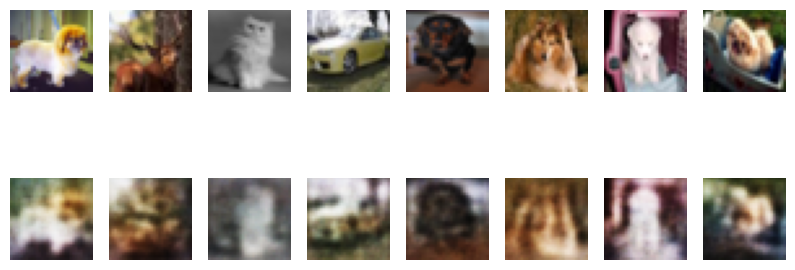

In [35]:
ae = Autoencoder()
ae = train_autoencoder(ae, dataloader, epochs=10)
print("Visualizing Autoencoder Reconstruction")
visualize_reconstruction(ae, dataloader)